<a href="https://colab.research.google.com/github/Jesolis14/pln/blob/main/analisis_sentimiento_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aspect-Based Sentiment Analysis (ABSA) con spaCy y Diccionarios

Este proyecto implementa un sistema de **Análisis de Sentimiento Basado en Aspectos (ABSA)** sobre reseñas de Amazon.  
A diferencia del análisis de sentimiento clásico, que asigna una etiqueta global por reseña, el ABSA detecta:

- **Aspectos**: características del producto mencionadas por los usuarios (ejemplo: *battery, screen, sound*).  
- **Opiniones**: palabras valorativas asociadas a esos aspectos (ejemplo: *good, bad, excellent, horrible*).  
- **Sentimiento por aspecto**: clasificación positiva, negativa o neutral, con un score numérico ajustado por intensificadores (*very, extremely*) y negaciones (*not, never*).

---

## Objetivos principales

1. Detectar automáticamente los aspectos más relevantes de las reseñas.  
2. Identificar las opiniones asociadas a esos aspectos.  
3. Asignar un sentimiento específico por cada par aspecto-opinión.  
4. Generar resúmenes por aspecto para identificar fortalezas y debilidades de un producto.


In [1]:
import pandas as pd
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
from collections import Counter

## Dataset y Preparación Inicial

El análisis se realiza sobre un dataset de reseñas de Amazon, almacenado en un archivo CSV:



In [2]:
df = pd.read_csv('amazon_reviews.csv')

In [3]:
df

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,Amazon,"Amazon Devices & Accessories,Amazon Device Acc...",NaN,2016-04-02T14:40:43Z,2017-08-13T08:28:46Z,NaN,NaN,alexavoiceremoteforamazonfiretvfiretvstick/b00...,...,3.0,https://www.amazon.com/Alexa-Voice-Remote-Amaz...,This is not the same remote that I got for my ...,I would be disappointed with myself if i produ...,NaN,NaN,GregAmandawith4,NaN,NaN,4 ounces
1593,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,Amazon,"Amazon Devices & Accessories,Amazon Device Acc...",NaN,2016-04-02T14:40:43Z,2017-08-13T08:28:46Z,NaN,NaN,alexavoiceremoteforamazonfiretvfiretvstick/b00...,...,1.0,https://www.amazon.com/Alexa-Voice-Remote-Amaz...,I have had to change the batteries in this rem...,Battery draining remote!!!!,NaN,NaN,Amazon Customer,NaN,NaN,4 ounces
1594,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,Amazon,"Amazon Devices & Accessories,Amazon Device Acc...",NaN,2016-04-02T14:40:43Z,2017-08-13T08:28:46Z,NaN,NaN,alexavoiceremoteforamazonfiretvfiretvstick/b00...,...,1.0,https://www.amazon.com/Alexa-Voice-Remote-Amaz...,"Remote did not activate, nor did it connect to...",replacing an even worse remote. Waste of time,NaN,NaN,Amazon Customer,NaN,NaN,4 ounces
1595,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,Amazon,"Amazon Devices & Accessories,Amazon Device Acc...",NaN,2016-04-02T14:40:43Z,2017-08-13T08:28:46Z,NaN,NaN,alexavoiceremoteforamazonfiretvfiretvstick/b00...,...,3.0,https://www.amazon.com/Alexa-Voice-Remote-Amaz...,It does the job but is super over priced. I fe...,Overpriced,NaN,NaN,Meg Ashley,NaN,NaN,4 ounces


## Léxico de Palabras Positivas

Para identificar opiniones favorables dentro de las reseñas se define un diccionario de palabras positivas.  
Cada palabra está asociada a un valor numérico que refleja la intensidad del sentimiento:

- **3**: palabras con una connotación altamente positiva.  
- **2**: palabras con una connotación positiva clara, pero no extrema.  
- **1**: palabras con una connotación ligeramente positiva o neutra.




In [4]:
palabras_positivas = {
    'excellent': 3, 'amazing': 3, 'fantastic': 3, 'outstanding': 3,
    'perfect': 3, 'brilliant': 3, 'superb': 3, 'wonderful': 3,
    'awesome': 3, 'incredible': 3, 'exceptional': 3,

    'good': 2, 'great': 2, 'nice': 2, 'love': 2, 'recommend': 2,
    'happy': 2, 'satisfied': 2, 'pleased': 2, 'impressed': 2,
    'beautiful': 2, 'comfortable': 2, 'reliable': 2, 'quality': 2,

    'ok': 1, 'okay': 1, 'fine': 1, 'decent': 1, 'useful': 1,
    'work': 1, 'function': 1, 'adequate': 1, 'reasonable': 1
}

## Léxico de Palabras Negativas

De forma análoga al léxico positivo, se define un diccionario de palabras negativas que permite identificar opiniones desfavorables en las reseñas.  
Cada palabra recibe un valor numérico negativo que representa la intensidad de la crítica:

- **−3**: palabras con una connotación fuertemente negativa.  
- **−2**: palabras con una connotación negativa clara.  
- **−1**: palabras con una connotación levemente negativa.


In [5]:
palabras_negativas = {
    'terrible': -3, 'horrible': -3, 'awful': -3, 'disgusting': -3,
    'hate': -3, 'worst': -3, 'pathetic': -3, 'useless': -3,
    'nightmare': -3, 'disaster': -3, 'trash': -3,

    'bad': -2, 'poor': -2, 'disappointing': -2, 'annoying': -2,
    'frustrating': -2, 'broken': -2, 'defective': -2, 'waste': -2,
    'uncomfortable': -2, 'difficult': -2, 'cheap': -2,

    'slow': -1, 'confusing': -1, 'small': -1, 'problem': -1,
    'issue': -1, 'trouble': -1, 'concern': -1, 'minor': -1
}


## Intensificadores y Negadores

Además de las palabras positivas y negativas, se definen dos diccionarios auxiliares que modifican la intensidad o polaridad del sentimiento detectado:

### Intensificadores

Los intensificadores aumentan la fuerza del sentimiento asociado a una opinión.  
Cada palabra está asociada a un factor de multiplicación mayor que 1.0.


In [6]:
intensificadores = {
    'very': 1.5, 'extremely': 2.0, 'really': 1.5, 'absolutely': 2.0,
    'completely': 2.0, 'totally': 1.8, 'quite': 1.3, 'pretty': 1.2,
    'so': 1.4, 'too': 1.3, 'highly': 1.6, 'incredibly': 1.8
}

negadores = {
    'not': -1.0, 'never': -1.0, 'no': -1.0, 'nothing': -1.0,
    'barely': 0.3, 'hardly': 0.3, 'somewhat': 0.7, 'slightly': 0.5,
    'little': 0.6, 'bit': 0.7, 'rather': 0.8
}

## Procesamiento con spaCy y Funciones Auxiliares

Para el análisis lingüístico se utiliza el modelo de spaCy:

In [ ]:
nlp = spacy.load("en_core_web_sm")

Este modelo proporciona tokenización, lematización y dependencias gramaticales, necesarias para detectar aspectos y opiniones.

####Lista de exclusión de aspectos

Se define un conjunto de términos genéricos que no deben ser considerados como aspectos válidos.
Estos términos suelen ser demasiado generales o no aportan información útil en el contexto de un producto.

In [ ]:
ASPECT_STOP = {
    "product","item","thing","stuff","purchase","seller","shop","amazon",
    "device","one", "apple"
}

####Función `_norm`

Normaliza un token a su lema en minúsculas.
Esto permite comparar palabras con los diccionarios definidos sin importar su forma original.

In [ ]:
def _norm(t):
    return t.lemma_.lower()

####Función `_mult_from_modifiers`

Calcula el multiplicador de un token de opinión en función de los modificadores que lo acompañan:

Si tiene intensificadores (advmod), multiplica el score según el diccionario de intensificadores.

Si tiene una negación (neg), invierte el signo del score.

In [ ]:
def _mult_from_modifiers(op_token):
    """
    Calcula multiplicador por intensificadores (advmod) y negación (neg)
    del token de opinión (adjetivo o verbo).
    """
    mult = 1.0
    # Intensificadores como advmod hijos
    for child in op_token.children:
        if child.dep_ == "advmod":
            w = _norm(child)
            if w in intensificadores:
                mult *= intensificadores[w]
    # Negación
    has_neg = any(child.dep_ == "neg" or _norm(child) in negadores for child in op_token.children)
    if has_neg:
        # Si tu diccionario de negadores tiene <1, úsalo. Si no, invierte el signo.
        # Aquí uso inversión de signo estándar:
        mult *= -1.0
    return mult

## Detección de Aspectos y Palabras de Opinión

Una vez definidos los diccionarios, se implementan funciones auxiliares que permiten identificar tanto las palabras de opinión como los posibles aspectos de cada reseña.

---

### Función `_score_from_lexicon`

Devuelve el valor de sentimiento asociado a un lema si se encuentra en el léxico de palabras positivas o negativas.  
En caso contrario devuelve `None`.

In [ ]:
def _score_from_lexicon(op_lemma):
    if op_lemma in palabras_positivas:
        return float(palabras_positivas[op_lemma])
    if op_lemma in palabras_negativas:
        return float(palabras_negativas[op_lemma])
    return None  # no es palabra de opinión

####Función `_is_valid_aspect`

Verifica si un token puede considerarse un aspecto válido:

Debe ser un sustantivo (`NOUN`) o nombre propio (`PROPN`).

No debe estar en la lista de exclusión `ASPECT_STOP`.

In [ ]:
def _is_valid_aspect(tok):
    return tok.pos_ in {"NOUN","PROPN"} and _norm(tok) not in ASPECT_STOP

####Función `_collect_aspects`

Extrae los candidatos a aspectos dentro de una oración:

La raíz de cada ´noun_chunk´ (grupo nominal).

Sustantivos o nombres propios sueltos que pasen el filtro de ´_is_valid_aspect´.

In [ ]:
def _collect_aspects(sent):
    """
    Candidatos de aspecto en la oración:
    - cabeza de noun_chunks
    - nombres/proper nouns sueltos
    """
    aspects = set()
    for chunk in sent.noun_chunks:
        head = chunk.root
        if _is_valid_aspect(head):
            aspects.add(head)
    for tok in sent:
        if _is_valid_aspect(tok):
            aspects.add(tok)
    return aspects

## Generación de Pares Aspecto–Opinión

Una vez identificados los aspectos y las palabras de opinión, es necesario construir un resultado estructurado que asocie ambos elementos.  
Para ello se utiliza la función `_emit`.

---

### Función `_emit`

Esta función recibe:
- Un token de aspecto (`aspect_tok`).  
- Un token de opinión (`opinion_tok`).  
- El texto completo de la oración (`sent_text`).  

Su objetivo es calcular el **score de sentimiento** y devolver un diccionario con la información del par.


In [ ]:
def _emit(aspect_tok, opinion_tok, sent_text):
    a = _norm(aspect_tok)
    o = _norm(opinion_tok)
    base = _score_from_lexicon(o)
    if base is None:
        return None
    mult = _mult_from_modifiers(opinion_tok)
    score = base * mult
    if score > 0.5:
        sentim = "positivo"
    elif score < -0.5:
        sentim = "negativo"
    else:
        sentim = "neutral"
    return {
        "aspect": a,
        "opinion": o,
        "sentiment": sentim,
        "score": round(score, 3),
        "sentence": sent_text,
        "aspect_span": aspect_tok.text,
        "opinion_span": opinion_tok.text
    }

## Extracción de Pares Aspecto–Opinión en una Oración

La función `absa_en_oracion` aplica reglas de dependencias gramaticales para identificar y relacionar aspectos con opiniones dentro de una oración.  
El resultado es una lista de diccionarios generados con la función `_emit`.


In [ ]:
def absa_en_oracion(sent):
    """
    Extrae pares (aspecto, opinión) con reglas de dependencias.
    """
    results = []
    aspects = _collect_aspects(sent)

    # Regla A: amod (adj → noun)
    # 'great screen' -> adj(amod)->noun
    for tok in sent:
        if tok.dep_ == "amod" and tok.head in aspects:
            maybe = _emit(tok.head, tok, sent.text)
            if maybe:
                results.append(maybe)

    # Regla B: copular / atributo
    # 'screen is great' -> adj(acomp/head) con nsubj nominal
    for tok in sent:
        if tok.pos_ == "ADJ":
            subj_nouns = [c for c in tok.children if c.dep_ in {"nsubj","nsubjpass"} and c in aspects]
            has_cop = any(c.dep_ == "cop" for c in tok.children) or tok.head.lemma_ in {"be"}
            if subj_nouns and (has_cop or tok.head == tok):
                for a in subj_nouns:
                    maybe = _emit(a, tok, sent.text)
                    if maybe:
                        results.append(maybe)

    # Regla C: verbo de opinión → objeto
    # 'I hate the battery' -> verb(opinion) + dobj/obj aspecto
    for tok in sent:
        if tok.pos_ == "VERB":
            o_base = _score_from_lexicon(_norm(tok))
            if o_base is not None:
                objs = [c for c in tok.children if c.dep_ in {"dobj","obj","attr"} and c in aspects]
                # También prep->pobj: 'complain about battery'
                for prep in [c for c in tok.children if c.dep_ == "prep"]:
                    objs += [c for c in prep.children if c.dep_ == "pobj" and c in aspects]
                for a in objs:
                    maybe = _emit(a, tok, sent.text)
                    if maybe:
                        results.append(maybe)

    return results

## Análisis de Texto Completo

La función `absa_texto` permite aplicar las reglas de extracción de pares aspecto–opinión sobre un texto completo.  
Divide el texto en oraciones y, para cada una, invoca `absa_en_oracion`.

In [ ]:
def absa_texto(texto):
    """
    Retorna lista de dicts (aspect, opinion, sentiment, score, sentence, spans) para un texto.
    """
    doc = nlp(texto)
    out = []
    for sent in doc.sents:
        out.extend(absa_en_oracion(sent))
    return out

## Análisis de un Dataset Completo

La función `absa_sobre_df` aplica el análisis de sentimiento basado en aspectos a todas las reseñas de un `DataFrame`.  
El resultado es un nuevo `DataFrame` con una fila por cada par aspecto–opinión detectado.


In [9]:
def absa_sobre_df(df, text_col="reviews.text", batch_size=256, n_process=1):
    """
    Corre ABSA sobre todo el DF con nlp.pipe para eficiencia.
    Devuelve un DataFrame 'exploded' con una fila por (aspecto, opinión).
    """
    rows = []
    textos = df[text_col].fillna("").astype(str).tolist()
    for i, doc in enumerate(nlp.pipe(textos, batch_size=batch_size, n_process=n_process, disable=["ner"])):
        if not doc.text.strip():
            continue
        for sent in doc.sents:
            pares = absa_en_oracion(sent)
            for p in pares:
                p["review_idx"] = i
                rows.append(p)
    if not rows:
        return pd.DataFrame(columns=["review_idx","aspect","opinion","sentiment","score","sentence","aspect_span","opinion_span"])
    return pd.DataFrame(rows)


## Resumen por Aspecto

Una vez obtenido el `DataFrame` granular con una fila por cada par aspecto–opinión (`df_absa`), es posible generar un resumen estadístico que muestre:

- **n**: número total de menciones del aspecto.  
- **score_mean**: valor promedio del score asociado al aspecto.  
- **pos_pct**: porcentaje de menciones positivas.  
- **neg_pct**: porcentaje de menciones negativas.  

In [10]:
# 1) ABSA granular (una fila por par aspecto-opinión)
df_absa = absa_sobre_df(df, text_col="reviews.text")

# 2) Resumen por aspecto (conteos y score medio)
resumen_aspectos = (
    df_absa
    .groupby("aspect")
    .agg(
        n=("aspect","size"),
        score_mean=("score","mean"),
        pos_pct=("sentiment", lambda s: (s=="positivo").mean()),
        neg_pct=("sentiment", lambda s: (s=="negativo").mean())
    )
    .sort_values(["n","score_mean"], ascending=[False, False])
)

In [11]:
df_absa

,aspect,opinion,sentiment,score,sentence,aspect_span,opinion_span,review_idx
0,paperwhite,love,positivo,2.0,"and I am loving my paperwhite, no regrets!",paperwhite,loving,0
1,use,good,positivo,2.0,"For sundry logistical reasons, Ive also made g...",use,good,3
2,will,good,positivo,2.0,"I take on many of them, however, Ive found tha...",will,best,3
3,user,happy,positivo,2.0,But...I was a fairly happy user of a Nook Touc...,user,happy,4
4,customer,happy,positivo,2.0,Then I lost the Nook and since no other device...,customer,happy,4
...,...,...,...,...,...,...,...,...
2235,remote,love,positivo,2.0,All in all I love this remote!,remote,love,1586
2236,time,work,positivo,1.0,My original remote is still functioning but wi...,time,working,1586
2237,time,work,positivo,1.0,My original remote is still functioning but wi...,time,working,1586
2238,tv,work,positivo,1.0,It is not an exact duplicate of the remote fac...,TV,works,1588


In [12]:
resumen_aspectos

,n,score_mean,pos_pct,neg_pct
aspect,,,,
sound,117,2.006838,0.991453,0.008547
set,113,2.000000,1.000000,0.000000
tablet,112,1.665179,0.883929,0.116071
feature,71,2.040845,1.000000,0.000000
review,64,-1.937500,0.015625,0.984375
...,...,...,...,...
question,1,-2.000000,0.000000,1.000000
carousel,1,-3.000000,0.000000,1.000000
flap,1,-3.000000,0.000000,1.000000


## Resultados y Estadísticas



## Limitaciones y Mejoras Futuras

### Limitaciones Actuales
- Dependencia de diccionarios predefinidos
- No considera sarcasmo o ironía
- Análisis contextual básico
- Solo procesa texto en inglés


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_absa_report_inline(df_absa, resumen_aspectos=None, top_k=15):
    """
    Grafica en pantalla los resultados clave de ABSA.
    - Distribución de sentimientos
    - Histograma de scores
    - Top aspectos por menciones
    - Top aspectos positivos/negativos por score medio
    - Boxplots de score por aspecto
    - Porcentaje positivo y negativo por aspecto
    """
    required_cols = {"aspect", "sentiment", "score"}
    if not required_cols.issubset(df_absa.columns):
        missing = required_cols - set(df_absa.columns)
        raise ValueError(f"df_absa no contiene columnas requeridas: {missing}")

    if resumen_aspectos is None:
        resumen_aspectos = (
            df_absa
            .groupby("aspect")
            .agg(
                n=("aspect", "size"),
                score_mean=("score", "mean"),
                pos_pct=("sentiment", lambda s: (s == "positivo").mean()),
                neg_pct=("sentiment", lambda s: (s == "negativo").mean())
            )
            .sort_values(["n", "score_mean"], ascending=[False, False])
        )

    # Top K por menciones
    top_aspects = resumen_aspectos.sort_values("n", ascending=False).head(top_k)

    # 1) Distribución de sentimiento
    counts = df_absa["sentiment"].value_counts().reindex(["positivo", "neutral", "negativo"])
    counts.plot(kind="bar")
    plt.title("Distribución de sentimiento (pares aspecto-opinión)")
    plt.xlabel("Sentimiento")
    plt.ylabel("Conteo")
    plt.show()

    # 2) Histograma de scores
    scores = df_absa["score"].dropna().values
    bins = max(10, int(math.sqrt(len(scores)))) if len(scores) > 0 else 10
    plt.hist(scores, bins=bins)
    plt.title("Histograma de scores (pares aspecto-opinión)")
    plt.xlabel("Score")
    plt.ylabel("Frecuencia")
    plt.show()

    # 3) Top aspectos por menciones
    top_aspects_sorted = top_aspects.sort_values("n", ascending=True)
    plt.barh(top_aspects_sorted.index.astype(str), top_aspects_sorted["n"].values)
    plt.title(f"Top {len(top_aspects_sorted)} aspectos por menciones")
    plt.xlabel("Menciones")
    plt.ylabel("Aspecto")
    plt.show()

    # 4) Top aspectos positivos por score medio
    min_n = max(5, int(np.percentile(resumen_aspectos["n"], 25))) if len(resumen_aspectos) else 5
    pos_candidates = resumen_aspectos[resumen_aspectos["n"] >= min_n].sort_values("score_mean", ascending=False).head(top_k)
    plt.barh(pos_candidates.index.astype(str), pos_candidates["score_mean"].values)
    plt.title("Top aspectos positivos por score medio")
    plt.xlabel("Score medio")
    plt.ylabel("Aspecto")
    plt.show()

    # 5) Top aspectos negativos por score medio
    neg_candidates = resumen_aspectos[resumen_aspectos["n"] >= min_n].sort_values("score_mean", ascending=True).head(top_k)
    plt.barh(neg_candidates.index.astype(str), neg_candidates["score_mean"].values)
    plt.title("Top aspectos negativos por score medio")
    plt.xlabel("Score medio")
    plt.ylabel("Aspecto")
    plt.show()

    # 6) Boxplots de score por aspecto
    aspects_for_box = top_aspects.index.tolist()
    df_box = df_absa[df_absa["aspect"].isin(aspects_for_box)][["aspect", "score"]].dropna()
    order = top_aspects.sort_values("n", ascending=False).index.tolist()
    data = [df_box.loc[df_box["aspect"] == a, "score"].values for a in order]
    plt.boxplot(data, labels=[str(a) for a in order], vert=True, showmeans=True)
    plt.title("Distribución de scores por aspecto")
    plt.xlabel("Aspecto")
    plt.ylabel("Score")
    plt.xticks(rotation=45, ha="right")
    plt.show()

    # 7) Barras de % positivo por aspecto
    df_rates = resumen_aspectos.loc[top_aspects.index][["pos_pct", "neg_pct"]].copy()
    y_pos = np.arange(len(df_rates))
    plt.barh(y_pos, df_rates["pos_pct"].values)
    plt.yticks(y_pos, df_rates.index.astype(str))
    plt.title("Porcentaje positivo por aspecto")
    plt.xlabel("Proporción positiva")
    plt.ylabel("Aspecto")
    plt.show()

    # 8) Barras de % negativo por aspecto
    plt.barh(y_pos, df_rates["neg_pct"].values)
    plt.yticks(y_pos, df_rates.index.astype(str))
    plt.title("Porcentaje negativo por aspecto")
    plt.xlabel("Proporción negativa")
    plt.ylabel("Aspecto")
    plt.show()


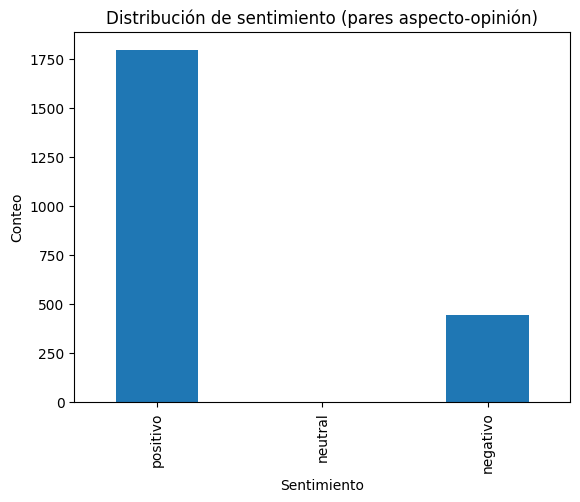

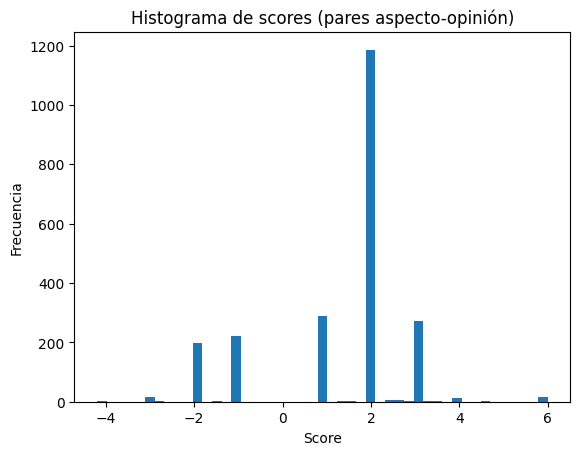

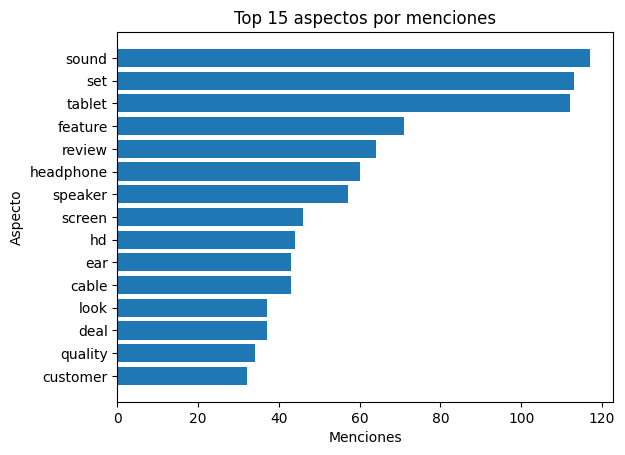

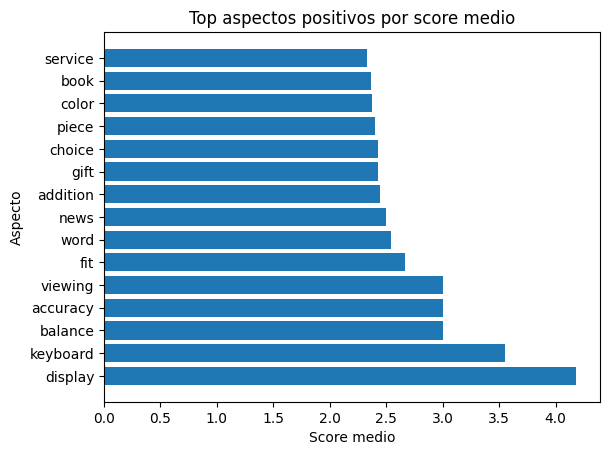

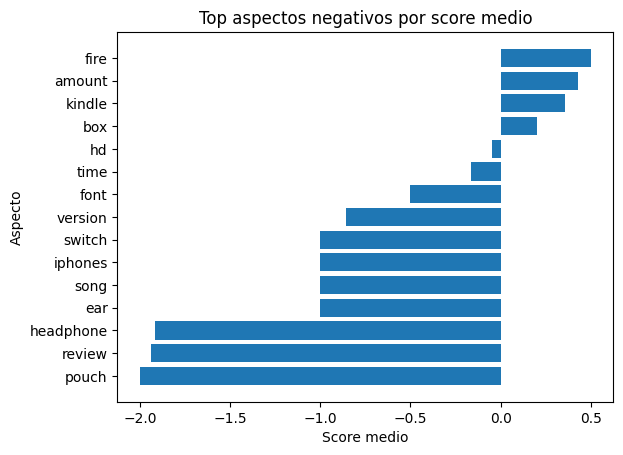

/tmp/ipython-input-3051486590.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(a) for a in order], vert=True, showmeans=True)


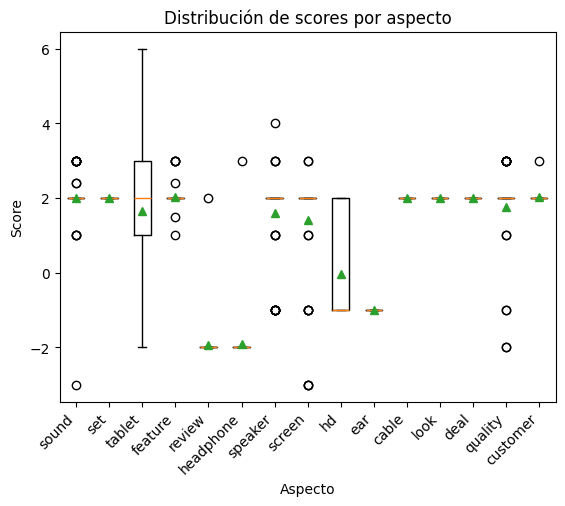

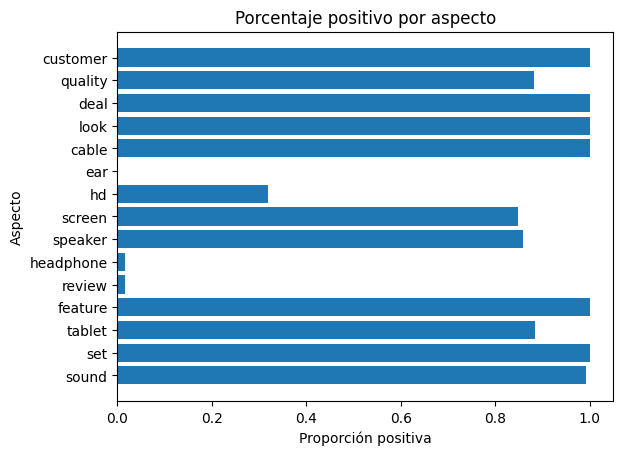

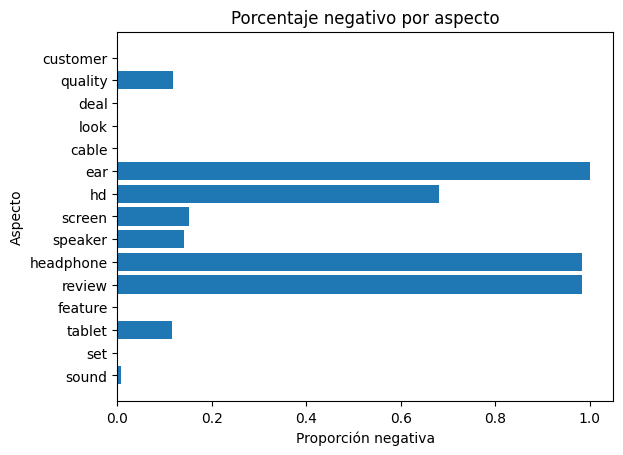

In [16]:
plot_absa_report_inline(df_absa, resumen_aspectos, top_k=15)